# ОПИСАНИЕ ДАННЫХ

Банки стремятся удержать как можно больше активных клиентов. Естественно, им любопытно узнать, удовлетворяются ли потребности их клиентской базы и планируют ли их клиенты покинуть компанию. Если банк подозревает, что его клиент потенциально может склониться к другой компании, банк может принять меры, чтобы убедить клиента остаться (целевая маркетинговая кампания, более личное отношение и т. д.).

Цель этой записной книжки — найти наиболее точную и точную модель для прогнозирования того, какие клиенты (тестовые данные) останутся, а какие колеблются и могут планировать покинуть компанию. Мы используем набор данных клиентов банка (10000 строк) с атрибутами, указанными ниже.

Набор данных имеет следующие атрибуты:

* Rownumber: уникальный идентификатор для каждой строки.  
* CustomerID: уникальный идентификатор для каждого клиента  
* Surname: фамилия клиента  
* CreditScore: кредитный рейтинг клиента  
* Geography: Страна происхождения клиента  
* Gender: Пол клиента  
* Age: Возраст клиента  
* Tenure: количество лет, в течение которых клиент работал в банке.  
* Balance: Баланс клиента на счете  
* NumOfProducts: количество продуктов клиента.  
* HasCrCard: Отметьте, есть ли у клиента кредитная карта или нет  
* IsActiveMember: отметьте, является ли клиент активным членом банка или нет  
* EstimatedSalary: ориентировочная годовая зарплата клиента в евро.  
* Exited: целевая переменная, флаг, покинул ли клиент банк или нет  

#ИССЛЕДУЕМ ДАННЫЕ

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install --q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.6 MB/s eta 0:00:00


In [3]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling  import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Churn_Modelling.csv')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
pip install --q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 30.9 MB/s eta 0:00:00


In [7]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

## ИССЛЕДУЕМ ВАЖНОСТЬ ПАРАМЕТРОВ

In [8]:
phik_overview = df.phik_matrix()
phik_overview['Exited'].round(2).sort_values()

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


/usr/local/lib/python3.8/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


RowNumber          0.00
Surname            0.00
HasCrCard          0.00
EstimatedSalary    0.00
Tenure             0.02
CustomerId         0.03
CreditScore        0.10
Geography          0.10
Gender             0.17
Balance            0.18
IsActiveMember     0.24
Age                0.49
NumOfProducts      0.57
Exited             1.00
Name: Exited, dtype: float64

## Определим наличие дубликатов

In [9]:
df.duplicated().sum()

0

In [10]:
df = df.drop(['RowNumber','Surname','CustomerId'], axis=1)

## Посмотрим баланс классов на целевой выборке

In [11]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

## Исследуем важные параметры

In [12]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [13]:
df.groupby(['Exited','NumOfProducts'])['NumOfProducts'].count()

Exited  NumOfProducts
0       1                3675
        2                4242
        3                  46
1       1                1409
        2                 348
        3                 220
        4                  60
Name: NumOfProducts, dtype: int64

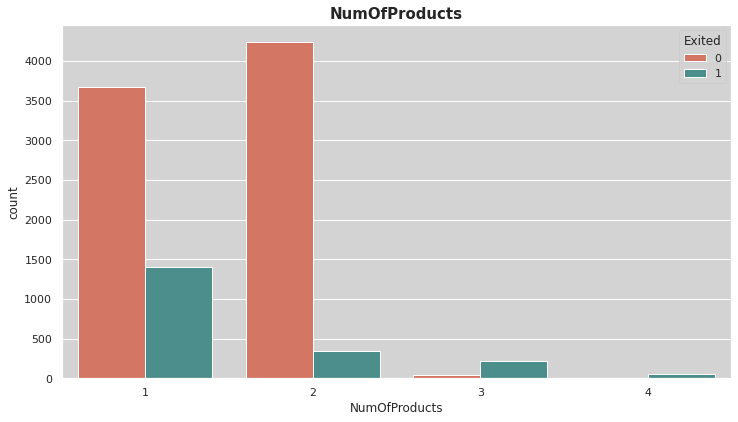

In [14]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(12,6.5)) 
plt.title('NumOfProducts', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'NumOfProducts', hue = 'Exited', palette=palette_features)

Здесь видно, что клиенты кто остался имеют два продукта в банке

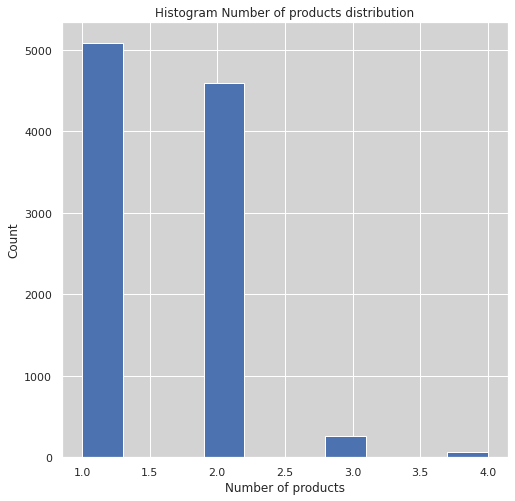

In [15]:
plt.figure(figsize=(8,8))
df.NumOfProducts.hist()
plt.xlabel('Number of products')
plt.ylabel('Count')
plt.title(r'Histogram Number of products distribution')
plt.show()

In [16]:
df.groupby(['Exited','HasCrCard'])['HasCrCard'].count()

Exited  HasCrCard
0       0            2332
        1            5631
1       0             613
        1            1424
Name: HasCrCard, dtype: int64

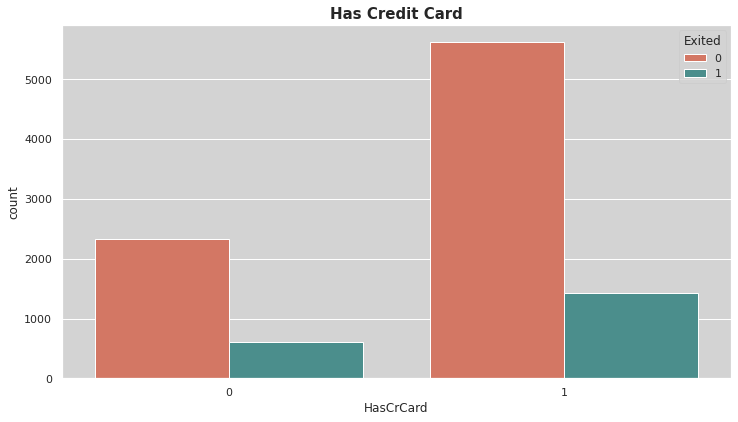

In [17]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(12,6.5)) 
plt.title('Has Credit Card', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'HasCrCard', hue = 'Exited', palette=palette_features)

Видно, что количество клиентов ушедших имели меньше кредитных карт

In [18]:
df.groupby(['Exited','IsActiveMember'])['IsActiveMember'].count()

Exited  IsActiveMember
0       0                 3547
        1                 4416
1       0                 1302
        1                  735
Name: IsActiveMember, dtype: int64

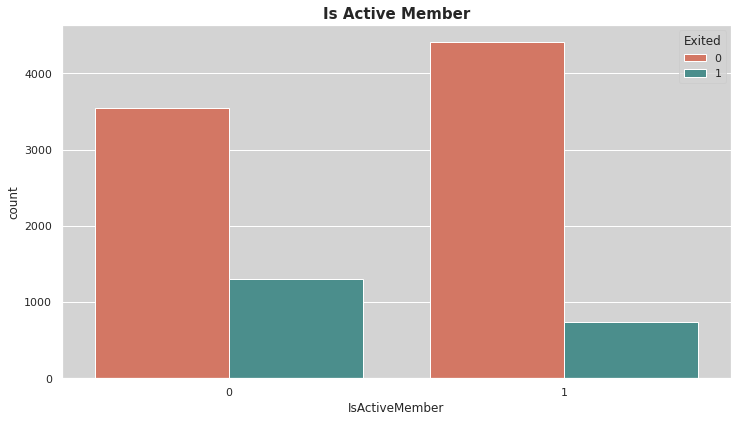

In [19]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(12,6.5)) 
plt.title('Is Active Member', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'IsActiveMember', hue = 'Exited', palette=palette_features)

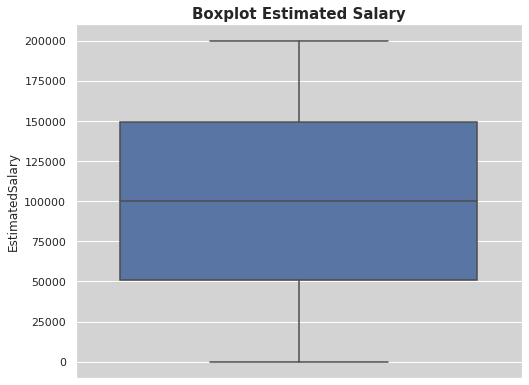

In [20]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot Estimated Salary', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="EstimatedSalary")
plt.show()

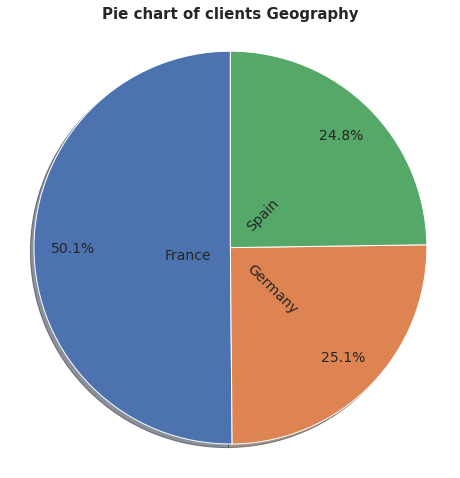

In [21]:
fig, ax = plt.subplots(figsize =(8, 9))
ax.pie(df['Geography'].value_counts(), labels=df['Geography'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.8,labeldistance=0.1, rotatelabels=True,textprops={'fontsize': 14},radius=1.1)
plt.title('Pie chart of clients Geography', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
plt.show()

In [22]:
pd.pivot_table(df, index= ['Exited'], columns=['Geography'], values='Balance', aggfunc = ['median'])

median                     
Geography    France    Germany     Spain
Exited                                  
0          49853.57  120252.02      0.00
1          80376.46  118951.22  79035.95

В Испании много клиентов с нулевым балансом

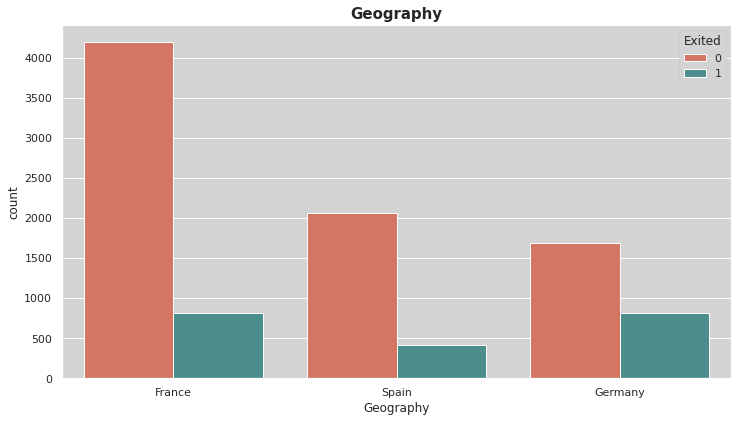

In [23]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(12,6.5)) 
plt.title('Geography', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'Geography', hue = 'Exited', palette=palette_features)

По графику видно, что больше всего клиентов банка из Франции, больший отток клиентов из Германии.

In [24]:
df.groupby(['Exited'],as_index = False)['Age'].median()

,Exited,Age
0,0,36.0
1,1,45.0


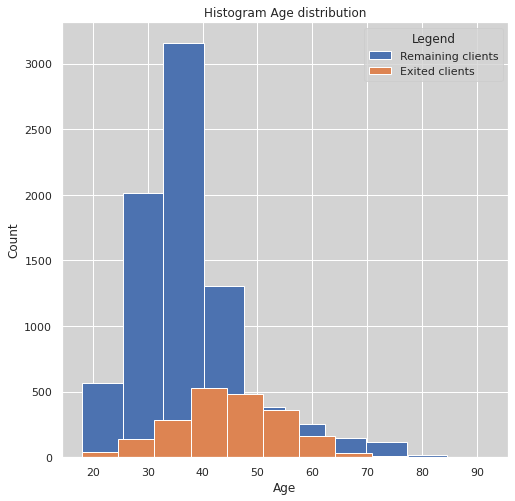

In [25]:
plt.figure(figsize=(8,8))
df.Age.loc[df['Exited']==0].hist()
df.Age.loc[df['Exited']==1].hist()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title(r'Histogram Age distribution')
plt.legend(title='Legend', loc='upper right', labels=['Remaining clients', 'Exited clients'])
plt.show()

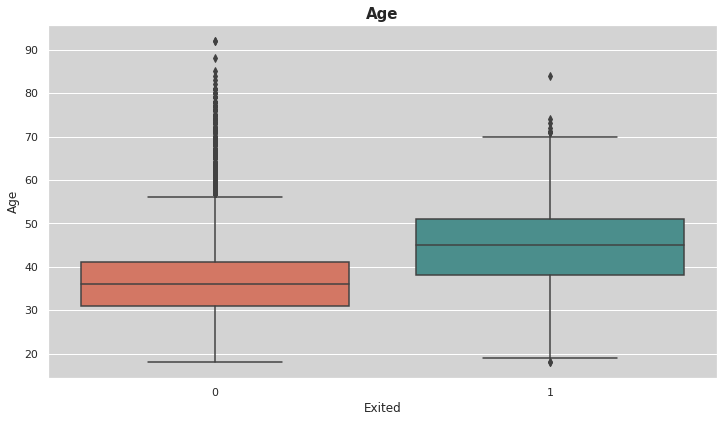

In [26]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'})
plt.figure(figsize=(12,6.5)) 
plt.title('Age', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.boxplot(x = df['Exited'], y = 'Age', data = df, palette=palette_features)

С банком остают всреднем более молодые люди

In [27]:
df.groupby(['Exited','Gender'])['Gender'].count()

Exited  Gender
0       Female    3404
        Male      4559
1       Female    1139
        Male       898
Name: Gender, dtype: int64

In [28]:
df.groupby(['Gender'])[['Exited']].mean()

,Exited
Gender,
Female,0.250715
Male,0.164559


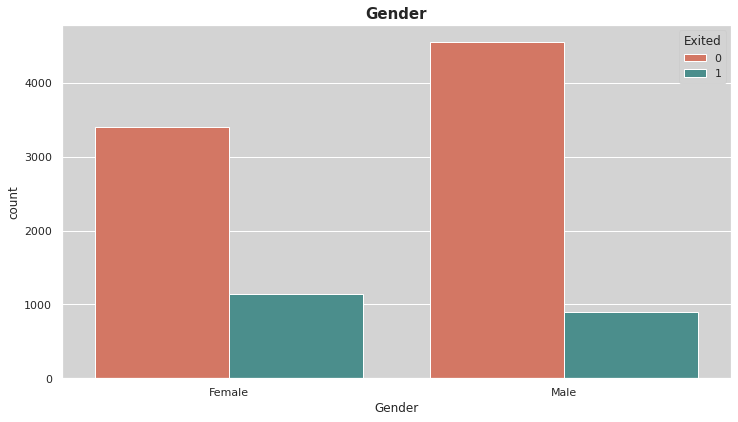

In [29]:
palette_features = ['#E56B51', '#409996']
sns.set(rc={'axes.facecolor':'lightgray'}) #background color of all plots

plt.figure(figsize=(12,6.5)) 
plt.title('Gender', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
ax = sns.countplot(data = df, x = 'Gender', hue = 'Exited', palette=palette_features)

Женщины чаще прекращают работу с банком. 25% женщин уходят, мужчин уходит 16%

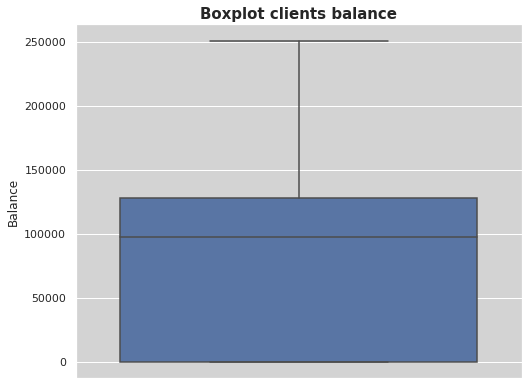

In [30]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot clients balance', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="Balance")
plt.show()

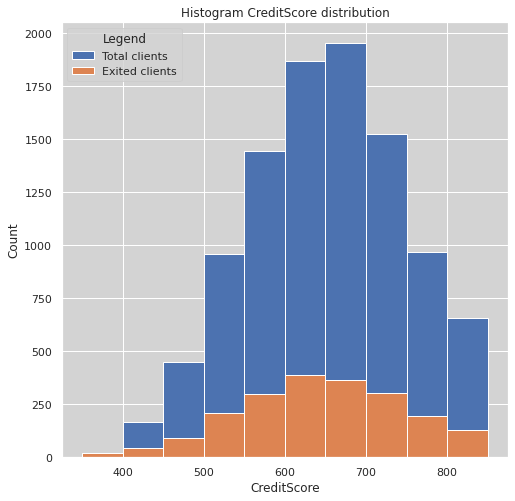

In [31]:
plt.figure(figsize=(8,8))
df.CreditScore.hist()
df.CreditScore.loc[df['Exited']==1].hist()
plt.xlabel('CreditScore')
plt.ylabel('Count')
plt.title(r'Histogram CreditScore distribution')
plt.legend(title='Legend', loc='upper left', labels=['Total clients', 'Exited clients'])
plt.show()

Люди уходят из банка с любым score, с самым низким уходят все

## Построим корреляцию

In [32]:
corr = df.corr().round(3)
corr['Exited']

CreditScore       -0.027
Age                0.285
Tenure            -0.014
Balance            0.119
NumOfProducts     -0.048
HasCrCard         -0.007
IsActiveMember    -0.156
EstimatedSalary    0.012
Exited             1.000
Name: Exited, dtype: float64

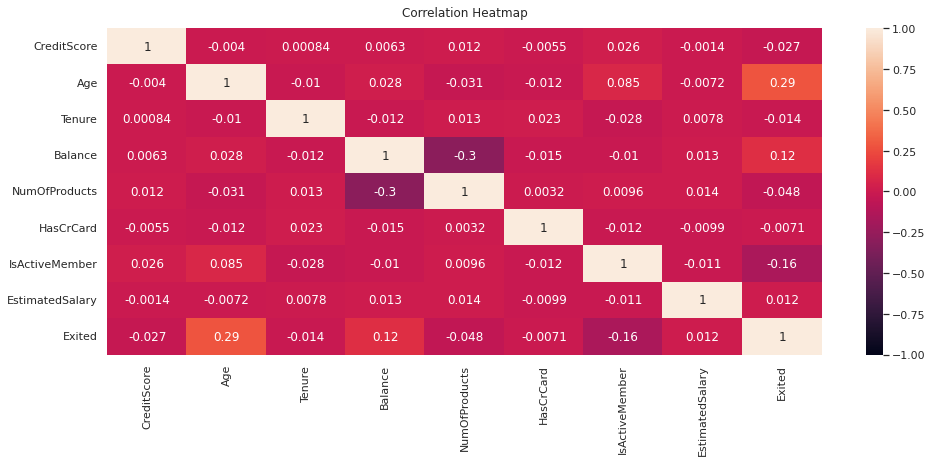

In [33]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Корреляция целевого признака с остаольными слабая. Самая большая корреляция с возрастом.

#Кодируем данные

In [34]:
cat_columns = list(df.select_dtypes(include=['object']).columns)

In [35]:
enc = OrdinalEncoder()
df.loc[:,cat_columns] = enc.fit_transform(df.loc[:,cat_columns])

In [36]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  float64
 2   Gender           10000 non-null  float64
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 859.5 KB


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.0,1.0,39,5,0.00,2,1,0,96270.64,0
9996,516,0.0,1.0,35,10,57369.61,1,1,1,101699.77,0
9997,709,0.0,0.0,36,7,0.00,1,0,1,42085.58,1
9998,772,1.0,1.0,42,3,75075.31,2,1,0,92888.52,1


## Масшатабируем данные

In [37]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(df[numeric]) 

df[numeric] = scaler.transform(df[numeric])

## Делим данные для модели

In [38]:
features = df.drop('Exited', axis=1)
target = df['Exited']

Доработаем баланс классов

In [39]:
smt = SMOTE()
features_res , target_res  = smt.fit_resample(features,target)
target_res.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

In [40]:
features_train, features_test, target_train, target_test = train_test_split (features_res , target_res, random_state=42, test_size=0.25)

#Построим модели

## LogisticRegression

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 42)

In [42]:
lr = LogisticRegression(random_state=42)

Подбираем гиперпараметры с помощью GridSearchCV

In [43]:
params_lr = {"C":np.logspace(-3,3,7)}
best_lr = GridSearchCV(estimator= lr, param_grid= params_lr, 
                         cv= skf, verbose= True, n_jobs= -1,scoring='f1')

In [44]:
best_lr.fit(features_train, target_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1', verbose=True)

In [45]:
lr_gs_best_params = best_lr.best_params_

In [46]:
best_lr.best_score_

0.7220329645820418

In [47]:
lr = LogisticRegression(random_state=42, **lr_gs_best_params)

In [48]:
lr.fit(features_train,target_train)
pred_lr = lr.predict(features_test)

In [49]:
print(classification_report(target_test, pred_lr))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      2036
           1       0.71      0.72      0.72      1946

    accuracy                           0.72      3982
   macro avg       0.72      0.72      0.72      3982
weighted avg       0.72      0.72      0.72      3982



In [50]:
lr_accuracy = accuracy_score(target_test, pred_lr)
lr_precision = precision_score(target_test, pred_lr)
lr_recall = recall_score(target_test, pred_lr)
lr_f1 = f1_score(target_test, pred_lr)

In [51]:
print(f'Logistic Redression \n accuracy: {lr_accuracy} \n precision: {lr_precision} \n recall: {lr_recall} \n f1: {lr_f1}')

Logistic Redression 
 accuracy: 0.7189854344550477 
 precision: 0.7078934137757668 
 recall: 0.723535457348407 
 f1: 0.7156289707750955


Получили метрики на невысоком уровне

[[1455  581]
 [ 538 1408]]


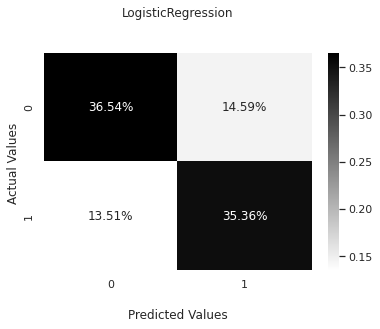

In [52]:
confusion_matrix(target_test, pred_lr)


cf_matrix_lr = confusion_matrix(target_test, pred_lr)
print(cf_matrix_lr)

ax = sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, fmt='.2%', cmap='binary')
ax.set_title('LogisticRegression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()

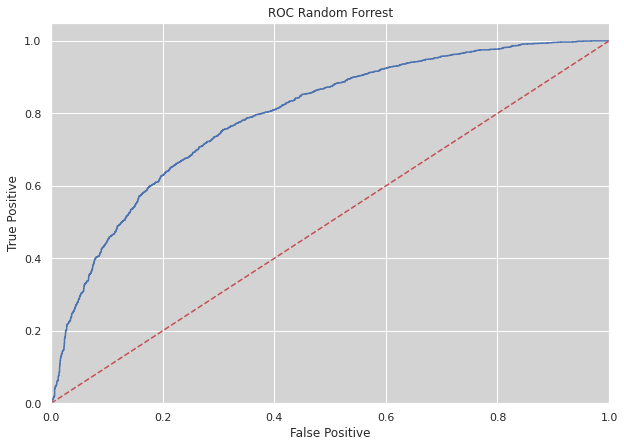

In [53]:
lr_auc_score=roc_auc_score(target_test,lr.predict(features_test))
fpr,tpr,thresholds=roc_curve(target_test,lr.predict_proba(features_test)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC(Area=%0.2f)"%lr_auc_score)
plt.plot([0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Random Forrest")
plt.show()

In [54]:
lr_auc_score

0.7190859997940463

Значение roc_auc так же на невымоком уровне

## RandomForestClassifier


Подбираем параметры с помощь GridSearchCV

In [55]:
rf = RandomForestClassifier(random_state=42)
params = {'max_depth': [10,20, 30,40,50],
         'min_samples_leaf': [3,6,9],
          'n_estimators': [100,200,300]}
best_tree = GridSearchCV(estimator= rf, param_grid= params, 
                         cv= skf, verbose= True, n_jobs= -1,scoring='f1')

In [56]:
best_tree.fit(features_train, target_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [3, 6, 9],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=True)

In [57]:
rf_gs_best_params = best_tree.best_params_

In [58]:
best_tree.best_score_

0.8731420566468714

Получили значение f1 лучше чем на предыдущей модели

In [59]:
pip install --q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 12.0 MB/s eta 0:00:00


Подбираем гиперпараметры с помощью optuna

In [60]:
import optuna
param_rf = {
            "max_depth": optuna.distributions.IntDistribution (2, 80),
            'min_samples_leaf': optuna.distributions.IntDistribution (2,40),
            'n_estimators': optuna.distributions.IntDistribution (50,500)
            }
optuna_search = optuna.integration.OptunaSearchCV(rf,param_rf, cv=3, scoring='f1',n_jobs=-1,n_trials=100)
optuna_search.fit(features_train, target_train)

<ipython-input-60-3ec0a18bed29>:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(rf,param_rf, cv=3, scoring='f1',n_jobs=-1,n_trials=100)
[I 2023-01-15 10:26:53,889] A new study created in memory with name: no-name-4273e999-8305-4004-bd62-987df057b190
[I 2023-01-15 10:27:16,667] Trial 1 finished with value: 0.8318545641824423 and parameters: {'max_depth': 19, 'min_samples_leaf': 27, 'n_estimators': 310}. Best is trial 1 with value: 0.8318545641824423.
[I 2023-01-15 10:27:16,715] Trial 0 finished with value: 0.823531312269885 and parameters: {'max_depth': 9, 'min_samples_leaf': 39, 'n_estimators': 326}. Best is trial 1 with value: 0.8318545641824423.
[I 2023-01-15 10:27:27,385] Trial 2 finished with value: 0.8271751159267068 and parameters: {'max_depth': 38, 'min_samples_leaf': 33, 'n_estimators': 119}. Best is trial 1 with value: 0.8318545641824423.
[I 2023-01-15 1

OptunaSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
               n_jobs=-1, n_trials=100,
               param_distributions={'max_depth': IntDistribution(high=80, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=40, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=50, step=1)},
               scoring='f1')

In [61]:
optuna_search.best_score_

0.875609981588083

Получили f1 еще лучше, будем использовать гиперпараметры полученные в ней

In [62]:
rf_best_params = optuna_search.best_params_

In [63]:
rf_optuna = RandomForestClassifier(random_state=42, **rf_best_params)

In [64]:
rf_optuna.fit(features_train,target_train)
pred_rf = rf_optuna.predict(features_test)

In [65]:
print(classification_report(target_test, pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2036
           1       0.88      0.89      0.88      1946

    accuracy                           0.89      3982
   macro avg       0.89      0.89      0.89      3982
weighted avg       0.89      0.89      0.89      3982



In [66]:
rf_accuracy = accuracy_score(target_test, pred_rf)
rf_precision = precision_score(target_test, pred_rf)
rf_recall = recall_score(target_test, pred_rf)
rf_f1 = f1_score(target_test, pred_rf)

In [67]:
print(f'Random Forrest \n accuracy: {rf_accuracy} \n precision: {rf_precision} \n recall: {rf_recall} \n f1: {rf_f1}')

Random Forrest 
 accuracy: 0.8852335509794074 
 precision: 0.8765806777946383 
 recall: 0.8905447070914697 
 f1: 0.8835075197552894


Получили довольно высокие значение метрик, посмотрим результаты на другой модели

[[1792  244]
 [ 213 1733]]


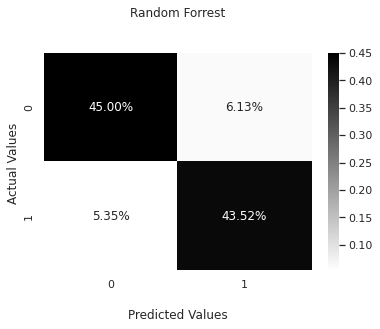

In [68]:
confusion_matrix(target_test, pred_rf)


cf_matrix_rf = confusion_matrix(target_test, pred_rf)
print(cf_matrix_rf)

ax = sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), annot=True, fmt='.2%', cmap='binary')
ax.set_title('Random Forrest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()

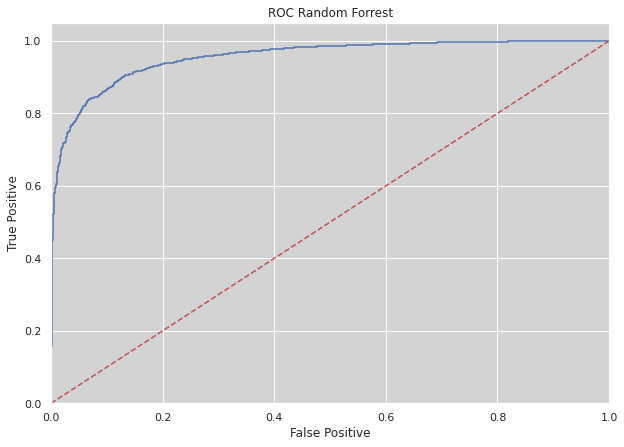

In [69]:
rf_optuna_auc_score=roc_auc_score(target_test,rf_optuna.predict(features_test))
fpr,tpr,thresholds=roc_curve(target_test,rf_optuna.predict_proba(features_test)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC(Area=%0.2f)"%rf_optuna_auc_score)
plt.plot([0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Random Forrest")
plt.show()

In [70]:
rf_optuna_auc_score

0.8853509390074243

Получили roc_auc значительно выше

## LGBMClassifier

In [71]:
import optuna

In [72]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()

In [73]:

param = {
        "lambda_l1": optuna.distributions.FloatDistribution(1e-8, 10.0, log=True),
        "lambda_l2": optuna.distributions.FloatDistribution(1e-8, 10.0, log=True),
        "num_leaves": optuna.distributions.IntDistribution(2, 256),
        "feature_fraction": optuna.distributions.FloatDistribution(0.4, 1.0),
        "bagging_fraction": optuna.distributions.FloatDistribution(0.4, 1.0),
        "bagging_freq": optuna.distributions.IntDistribution(1, 7),
        "min_child_samples": optuna.distributions.IntDistribution(5, 100)}

optuna_search = optuna.integration.OptunaSearchCV(lgbm,param, cv=3, scoring='f1',n_jobs=-1,n_trials=100)
optuna_search.fit(features_train, target_train)

<ipython-input-73-3b570e74ed1d>:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(lgbm,param, cv=3, scoring='f1',n_jobs=-1,n_trials=100)
[I 2023-01-15 10:36:51,678] A new study created in memory with name: no-name-f3b6ea48-1995-4c3a-a1d7-0801024c9e3a
[I 2023-01-15 10:36:55,585] Trial 0 finished with value: 0.8733841488515689 and parameters: {'lambda_l1': 0.36611057722354456, 'lambda_l2': 5.064328942570145, 'num_leaves': 235, 'feature_fraction': 0.6245335721536521, 'bagging_fraction': 0.720556240764823, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 0 with value: 0.8733841488515689.
[I 2023-01-15 10:36:57,812] Trial 1 finished with value: 0.8870024770843602 and parameters: {'lambda_l1': 1.490670091764306e-07, 'lambda_l2': 0.008244244829284344, 'num_leaves': 238, 'feature_fraction': 0.960670942109502, 'bagging_fraction': 0.8270189297424202, 'bagging_freq

OptunaSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1, n_trials=100,
               param_distributions={'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None),
                                    'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1),
                                    'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None),
                                    'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None),
                                    'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None),
                                    'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1),
                                    'num_leaves': IntDistribution(high=256, log=False, low=2, step=1)},
               scoring='f1')

In [74]:
optuna_search.best_score_

0.8987043849222213

Получили высокое значение f1 для модели

In [75]:
lgbm_best_params = optuna_search.best_params_

In [76]:
lgbm_optuna = lgb.LGBMClassifier(random_state=42, **lgbm_best_params)

In [77]:
lgbm_optuna.fit(features_train,target_train)
pred_lgbm = lgbm_optuna.predict(features_test)

In [78]:
print(classification_report(target_test, pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2036
           1       0.88      0.89      0.88      1946

    accuracy                           0.89      3982
   macro avg       0.89      0.89      0.89      3982
weighted avg       0.89      0.89      0.89      3982



In [79]:
lgbm_accuracy = accuracy_score(target_test, pred_lgbm)
lgbm_precision = precision_score(target_test, pred_lgbm)
lgbm_recall = recall_score(target_test, pred_lgbm)
lgbm_f1 = f1_score(target_test, pred_lgbm)

In [80]:
print(f'LightGBM \n accuracy: {lgbm_accuracy} \n precision: {lgbm_precision} \n recall: {lgbm_recall} \n f1: {lgbm_f1}')

LightGBM 
 accuracy: 0.9033149171270718 
 precision: 0.917156600748263 
 recall: 0.881808838643371 
 f1: 0.8991354466858789


Значение на тестовой выборке еще немного лучше

[[1881  155]
 [ 230 1716]]


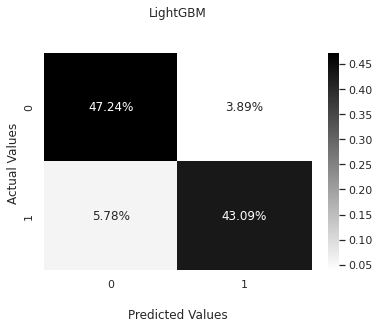

In [81]:
confusion_matrix(target_test, pred_lgbm)


cf_matrix_lgbm = confusion_matrix(target_test, pred_lgbm)
print(cf_matrix_lgbm)

ax = sns.heatmap(cf_matrix_lgbm/np.sum(cf_matrix_lgbm), annot=True, fmt='.2%', cmap='binary')
ax.set_title('LightGBM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()

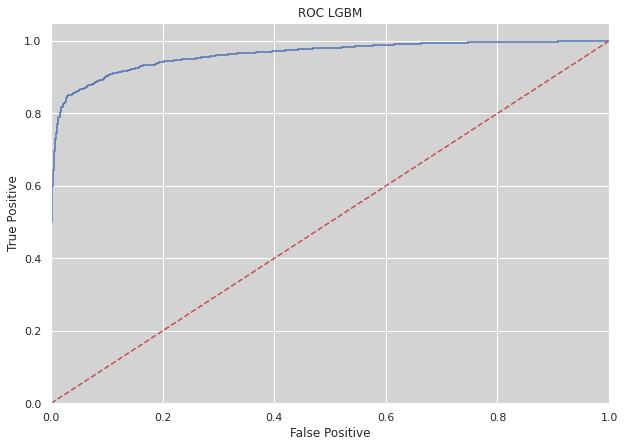

In [82]:
lgbm_auc_score=roc_auc_score(target_test,lgbm_optuna.predict(features_test))
fpr,tpr,thresholds=roc_curve(target_test,lgbm_optuna.predict_proba(features_test)[:,1])
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC(Area=%0.2f)"%lgbm_auc_score)
plt.plot([0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC LGBM")
plt.show()

# Свод по моделям

In [83]:
model_1 = {'accuracy': lr_accuracy.round(2),
           'precision': lr_precision.round(2),
           'recall': lr_recall.round(2),
           'f1': lr_f1.round(2)}
model_2 = {'accuracy': lgbm_accuracy.round(2),
           'precision': lgbm_precision.round(2),
           'recall': lgbm_recall.round(2),
           'f1': lgbm_f1.round(2)}
model_3 = {'accuracy': rf_accuracy.round(2),
           'precision': rf_precision.round(2),
           'recall': rf_recall.round(2),
           'f1': rf_f1.round(2)}


In [84]:
Models = pd.DataFrame([model_1, model_2, model_3], 
                      index=['Logistic Regression', 'Random Forrest', 'LightGBM'])

In [85]:
Models

,accuracy,precision,recall,f1
Logistic Regression,0.72,0.71,0.72,0.72
Random Forrest,0.90,0.92,0.88,0.90
LightGBM,0.89,0.88,0.89,0.88


# ВЫВОД

Мы обучили три модели с подбором гиперпараметров двумя способами optuna и GridSearchCV. Optuna показала себя лучше. Лучшая модель среди всех оказалась RandomForrest по всем метрикам.